# Time Series Forecasting using XGBoost

The following project works with hourly energy consumption data available on Kaggle (https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption). I will be using EDA and XGBoost, which is an ensemble Machine learning algorithm to create a model for prediction of energy consumption

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('PJME_hourly.csv')

In [3]:
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [4]:
# set index as DateTime column
df = df.set_index('Datetime')

In [5]:
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


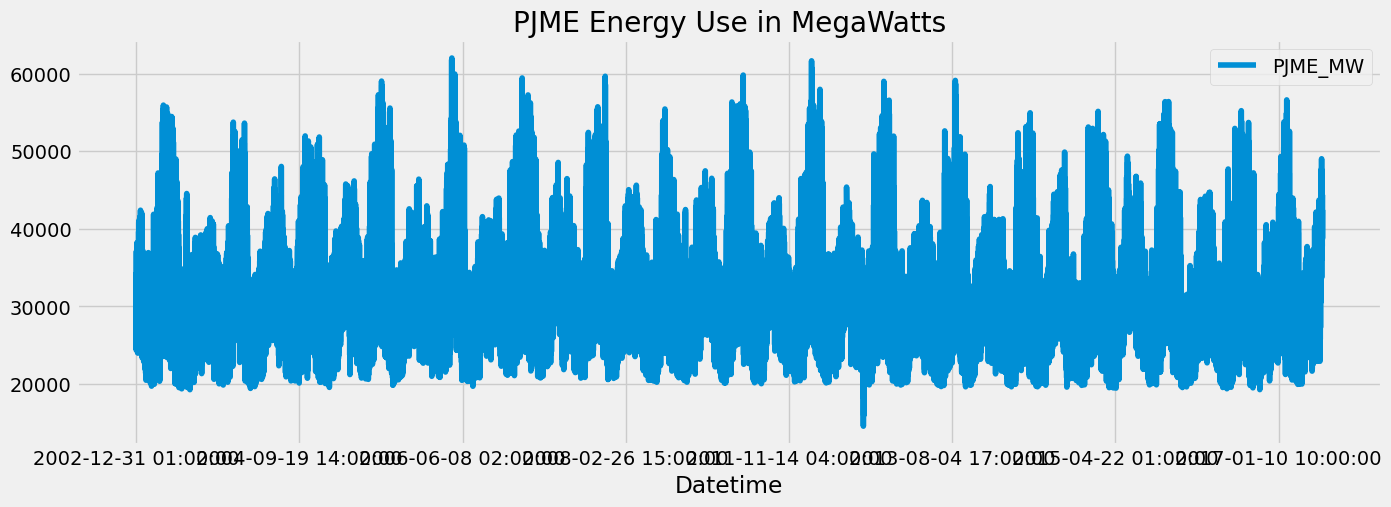

In [6]:
df.plot(figsize=(15,5),title='PJME Energy Use in MegaWatts')
plt.show()

In [7]:
# the DateTime column is 'Object' type and has to be converted to DateTime type for our application
df.index

Index(['2002-12-31 01:00:00', '2002-12-31 02:00:00', '2002-12-31 03:00:00',
       '2002-12-31 04:00:00', '2002-12-31 05:00:00', '2002-12-31 06:00:00',
       '2002-12-31 07:00:00', '2002-12-31 08:00:00', '2002-12-31 09:00:00',
       '2002-12-31 10:00:00',
       ...
       '2018-01-01 15:00:00', '2018-01-01 16:00:00', '2018-01-01 17:00:00',
       '2018-01-01 18:00:00', '2018-01-01 19:00:00', '2018-01-01 20:00:00',
       '2018-01-01 21:00:00', '2018-01-01 22:00:00', '2018-01-01 23:00:00',
       '2018-01-02 00:00:00'],
      dtype='object', name='Datetime', length=145366)

In [8]:
pd.to_datetime(df.index)

DatetimeIndex(['2002-12-31 01:00:00', '2002-12-31 02:00:00',
               '2002-12-31 03:00:00', '2002-12-31 04:00:00',
               '2002-12-31 05:00:00', '2002-12-31 06:00:00',
               '2002-12-31 07:00:00', '2002-12-31 08:00:00',
               '2002-12-31 09:00:00', '2002-12-31 10:00:00',
               ...
               '2018-01-01 15:00:00', '2018-01-01 16:00:00',
               '2018-01-01 17:00:00', '2018-01-01 18:00:00',
               '2018-01-01 19:00:00', '2018-01-01 20:00:00',
               '2018-01-01 21:00:00', '2018-01-01 22:00:00',
               '2018-01-01 23:00:00', '2018-01-02 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=145366, freq=None)

In [9]:
df.index = pd.to_datetime(df.index)

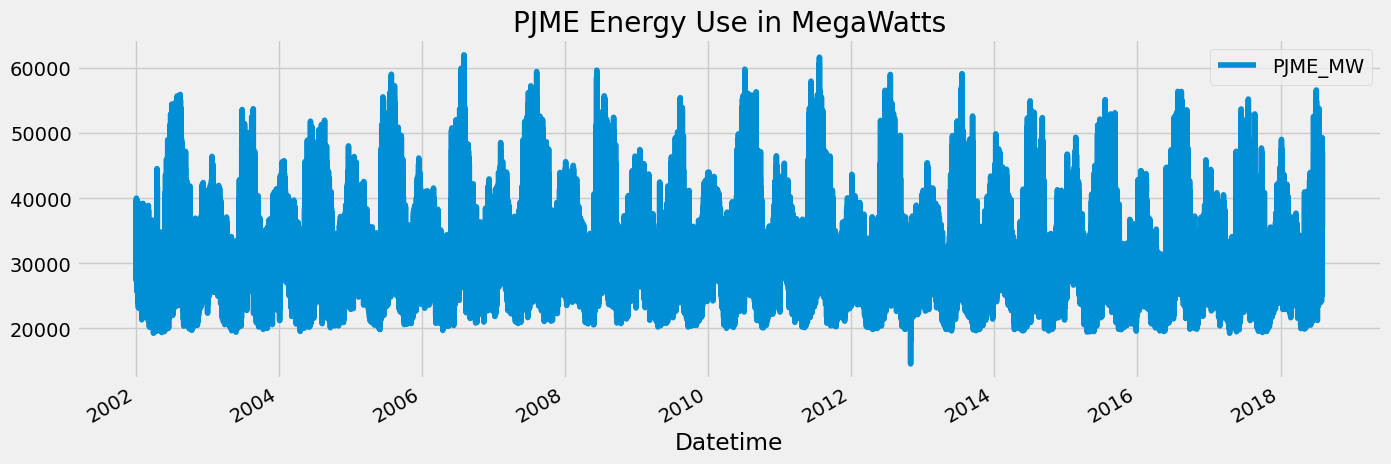

In [10]:
df.plot(figsize=(15,5),title='PJME Energy Use in MegaWatts')
plt.show()

# Train Test

In [11]:
# data prior to 2015, will be used as training data. Data post 2015 will be used to test the model
train = df[df.index<'01-01-2015']
test = df[df.index>='01-01-2015']

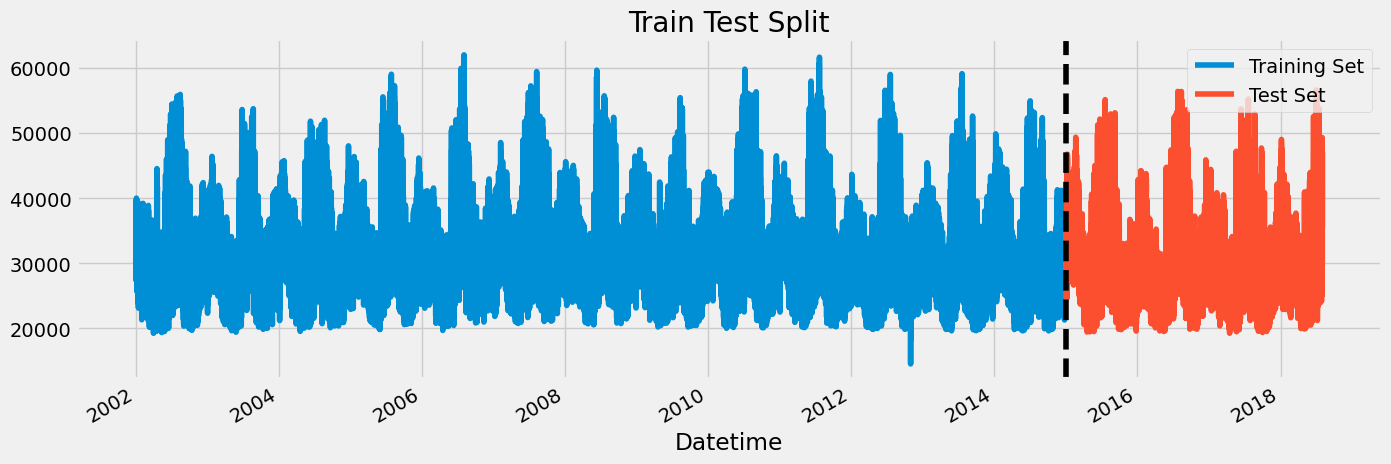

In [12]:
fig,ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax)
test.plot(ax=ax)
ax.axvline('01-01-2015',color='black',ls='--')
ax.legend(['Training Set','Test Set'])
plt.title('Train Test Split')
plt.show()

On Looking at the data for a particular week we can observe expected trends, like consumption being more at night and consumption being greater on weekends

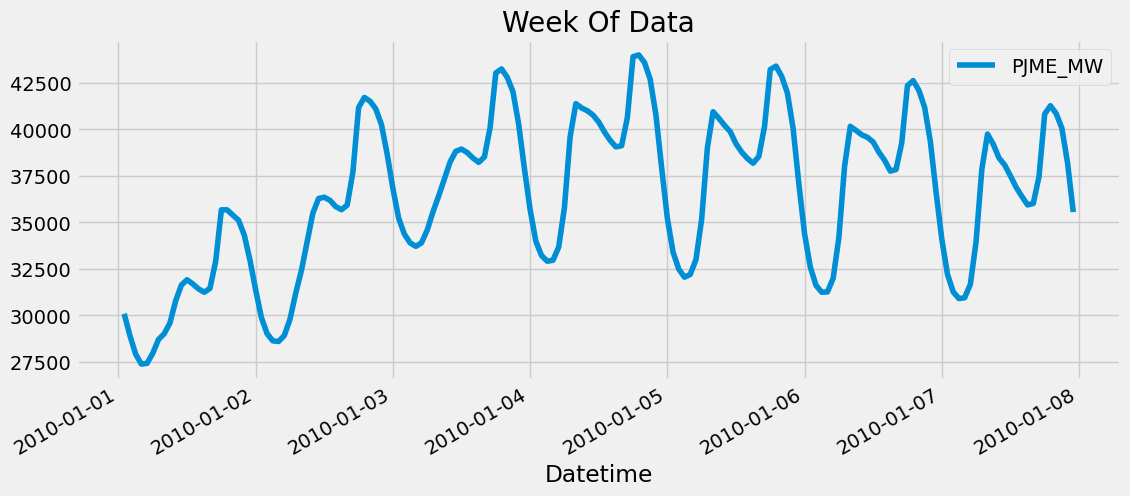

In [13]:
df[(df.index>'01-01-2010') & (df.index<'01-08-2010')].plot(figsize=(12,5),title='Week Of Data')
plt.show()

# Feature Creation

In [14]:
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['quarter'] = df.index.quarter
df['month'] = df.index.month
df['year'] = df.index.year
df['dayofyear'] = df.index.dayofyear

In [15]:
def feature_creation(df):
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

In [16]:
df.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear
Datetime,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365


# Visualise Feature/Target Relationship

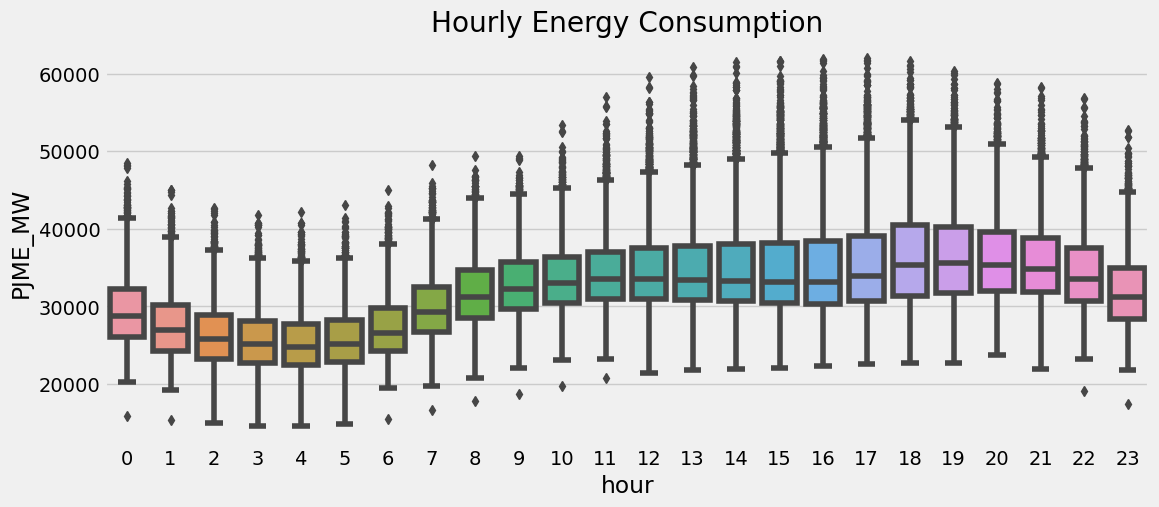

In [17]:
fig,ax = plt.subplots(figsize=(12,5))
sns.boxplot(x='hour',y='PJME_MW',data=df,ax=ax)
plt.title('Hourly Energy Consumption')
plt.show()

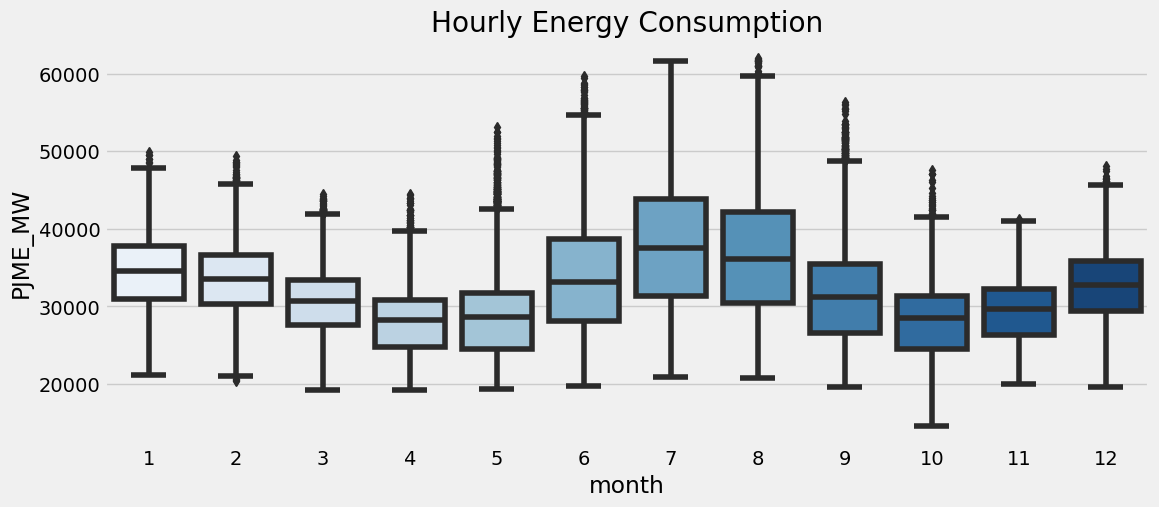

In [18]:
fig,ax = plt.subplots(figsize=(12,5))
sns.boxplot(x='month',y='PJME_MW',data=df,ax=ax,palette='Blues')
plt.title('Hourly Energy Consumption')
plt.show()

# Model Creation

In [19]:
train = feature_creation(train)
test = feature_creation(test)

In [20]:
df.columns
FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear']
TARGET = 'PJME_MW'

In [21]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [22]:
reg = xgb.XGBRegressor(n_estimators = 1000,early_stopping_rounds=50,learning_rate=0.01)
reg.fit(X_train,y_train,eval_set = [(X_train,y_train),(X_test,y_test)],verbose=100)

[0]	validation_0-rmse:32601.87826	validation_1-rmse:31654.28935
[100]	validation_0-rmse:12342.17856	validation_1-rmse:11516.21767
[200]	validation_0-rmse:5373.20460	validation_1-rmse:5164.97392
[300]	validation_0-rmse:3375.48321	validation_1-rmse:3834.00707
[400]	validation_0-rmse:2884.85132	validation_1-rmse:3716.33146
[451]	validation_0-rmse:2771.05175	validation_1-rmse:3731.37067


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [23]:
reg.feature_importances_

array([0.44880438, 0.1586678 , 0.03331862, 0.22815645, 0.02263376,
       0.10841895], dtype=float32)

In [24]:
pd.DataFrame(data=reg.feature_importances_,index=reg.feature_names_in_,columns=['importance'])

,importance
hour,0.448804
dayofweek,0.158668
quarter,0.033319
month,0.228156
year,0.022634
dayofyear,0.108419


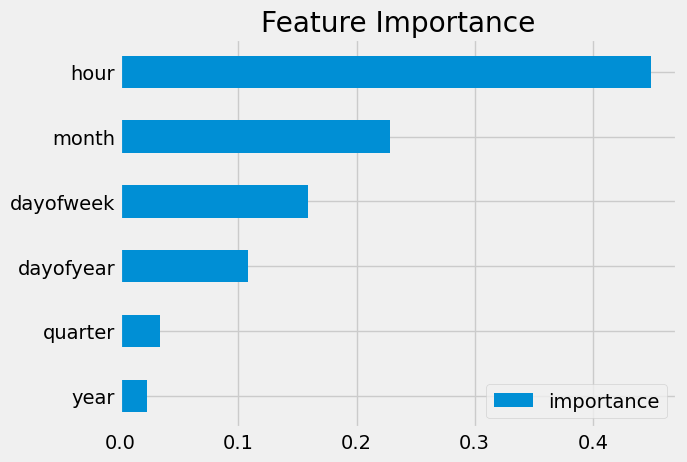

In [25]:
fi = pd.DataFrame(data=reg.feature_importances_,index=reg.feature_names_in_,columns=['importance'])
fi.sort_values(by='importance').plot(kind='barh',title='Feature Importance')
plt.show()

# Validating Predictions

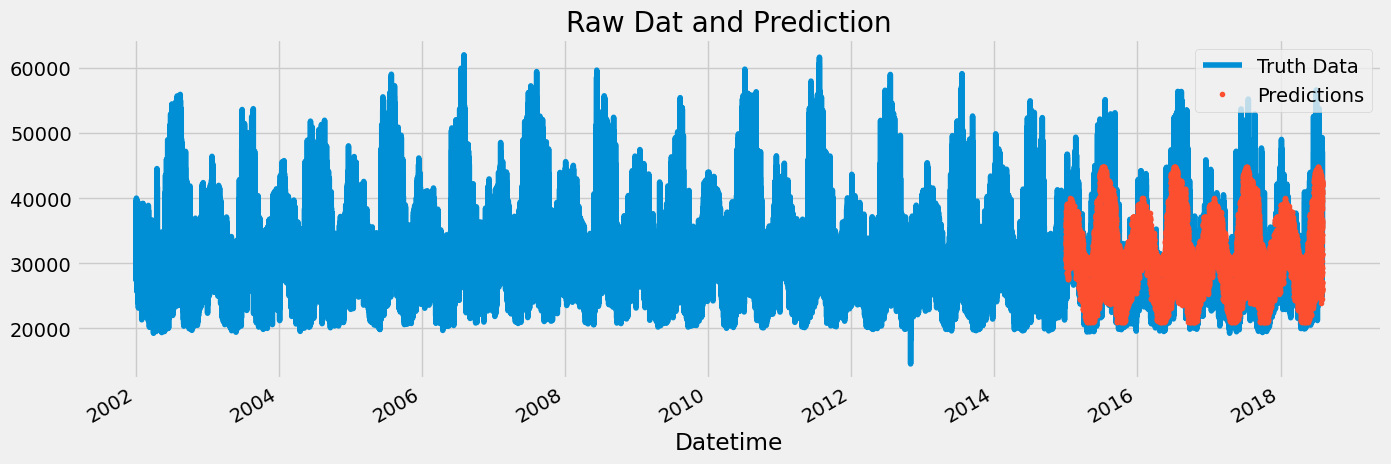

In [26]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

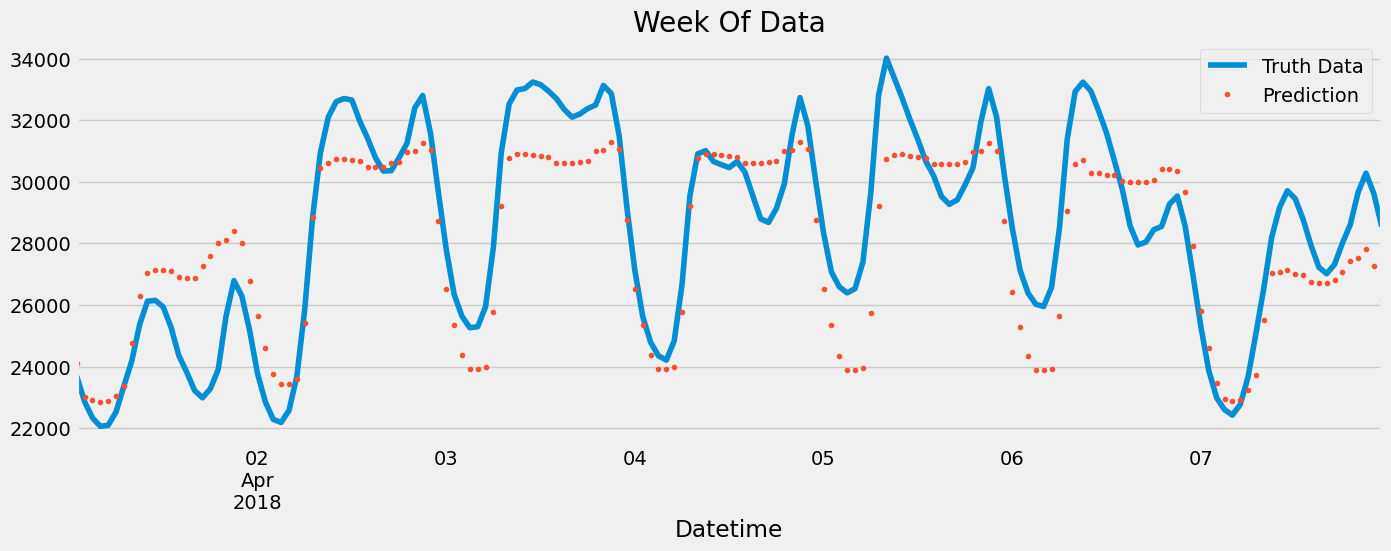

In [27]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

In [28]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3715.93
